In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from joblib import dump, load

from nltk.tokenize import RegexpTokenizer
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb

from util import *
from model import *
%matplotlib inline

In [94]:
# Importing the data set, both train and test, and concatenating both

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train['train_test'] = 'train'
test['train_test'] = 'test'

data = pd.concat([train, test])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [97]:
data.shape, test.shape

((258210, 16), (83210, 16))

In [98]:
data

,country,description,designation,id,index,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,train_test,variety,winery
0,Portugal,This is a fine rich balanced wine. It has ripe...,Vila Santa Reserva,32027,NaN,88.870874,20.0,Alentejano,NaN,NaN,NaN,NaN,NaN,train,PORTUGUESE RED,J. Portugal Ramos
1,France,"A solid, chunky wine, with a structure that is...",NaN,71079,NaN,88.041695,28.0,Bordeaux,Lalande de Pomerol,NaN,NaN,NaN,NaN,train,BORDEAUX-STYLE RED BLEND,Château Tour Grand Colombier
2,France,"This is powerful and concentrated, with the hi...",NaN,32440,NaN,94.085021,130.0,Bordeaux,Saint-Émilion,NaN,NaN,NaN,NaN,train,BORDEAUX-STYLE RED BLEND,Château Figeac
3,US,"Rich, ripe and oaky, this Petite Sirah charms ...",Thompson Vineyard,124405,NaN,89.869797,34.0,California,Santa Barbara County,Central Coast,NaN,NaN,Jaffurs 2010 Thompson Vineyard Petite Sirah (S...,train,PETITE SIRAH,Jaffurs
4,US,This wine is a unique in the state blend and f...,McKinley Springs Vineyard,33649,NaN,89.017651,24.0,Washington,Horse Heaven Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Syncline 2016 McKinley Springs Vineyard Rosé (...,train,ROSé,Syncline
5,Spain,This brut nature is citric and bubbly on the p...,Brut Nature Reserva,20153,NaN,83.118679,13.0,Catalonia,Cava,NaN,Michael Schachner,@wineschach,Mas Fi NV Brut Nature Reserva Sparkling (Cava),train,SPARKLING BLEND,Mas Fi
6,France,"A ripe wine that has red-berry fruits, slices ...",Cuvée Prestige,72654,NaN,88.320513,35.0,Bordeaux,Bordeaux Supérieur,NaN,Roger Voss,@vossroger,Château Tayet 2014 Cuvée Prestige (Bordeaux S...,train,BORDEAUX-STYLE RED BLEND,Château Tayet
7,Italy,From one of Sicily's most beautiful and promis...,Baccante,117626,NaN,85.173533,42.0,Sicily & Sardinia,Sicilia,NaN,NaN,NaN,NaN,train,WHITE BLEND,Abbazia Santa Anastasia
8,US,This wine plays close to the edge of overripe-...,NaN,112993,NaN,85.908686,38.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Matrix 2013 Pinot Noir (Russian River Valley),train,PINOT NOIR,Matrix
9,Italy,This basic Prosecco is perfectly quaffable tha...,Lellè Extra Dry,32542,NaN,81.929514,14.0,Veneto,Prosecco,NaN,NaN,NaN,NaN,train,GLERA,Fattoria Giuseppe Savini


In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258210 entries, 0 to 83209
Data columns (total 16 columns):
country                  258146 non-null object
description              258210 non-null object
designation              181120 non-null object
id                       258210 non-null int64
index                    83210 non-null float64
points                   258210 non-null float64
price                    175000 non-null float64
province                 258146 non-null object
region_1                 215793 non-null object
region_2                 110996 non-null object
taster_name              96479 non-null object
taster_twitter_handle    91559 non-null object
title                    120975 non-null object
train_test               258210 non-null object
variety                  258209 non-null object
winery                   258210 non-null object
dtypes: float64(3), int64(1), object(12)
memory usage: 38.5+ MB


In [100]:
data.describe()

,id,index,points,price
count,258210.000000,83210.000000,258210.000000,175000.000000
mean,61312.957329,70807.640680,88.084734,34.304400
std,39102.177584,41392.557418,3.157554,38.398146
min,0.000000,0.000000,79.636128,4.000000
25%,28728.000000,35202.000000,85.969390,16.000000
50%,57518.500000,70405.000000,87.981722,25.000000
75%,88859.750000,105730.500000,90.088168,40.000000
max,150929.000000,150928.000000,100.220603,2500.000000


In [103]:
selected_data = ['price', 'id','points']   # selecting the needed columns for the correlation test
data[selected_data].corr(method="pearson")

,price,id,points
price,1.000000,-0.023252,0.443276
id,-0.023252,1.000000,-0.051718
points,0.443276,-0.051718,1.000000


/usr/lib/python3/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/lib/python3/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


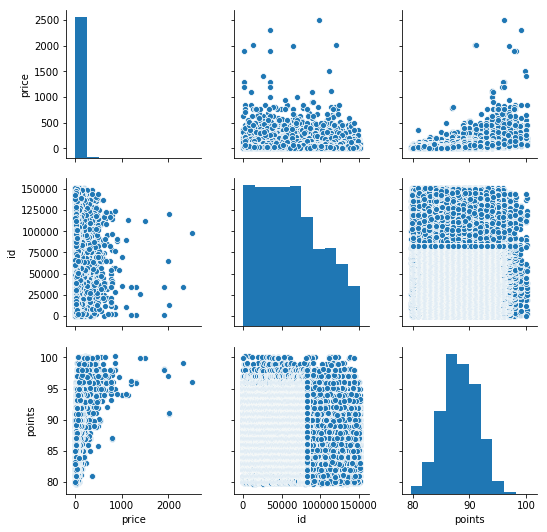

In [96]:
sns.pairplot(data[selected_data])

In [6]:
data['province'].mode()

0    California
dtype: object

In [7]:
data['variety'].mode()

0    PINOT NOIR
dtype: object

In [8]:
data['taster_twitter_handle'].mode()

0    @vossroger
dtype: object

In [9]:
data.variety.fillna(value='PINOT NOIR', inplace=True)

In [10]:
data.province.fillna(value='California', inplace=True)

In [11]:
data.taster_twitter_handle.fillna(value='@vossroger', inplace=True)

In [12]:
#data = data[pd.notnull(data['variety'])]
#data = data[pd.notnull(data['province'])]

In [13]:
data.taster_name.fillna(value='Roger Voss', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258210 entries, 0 to 83209
Data columns (total 16 columns):
country                  258146 non-null object
description              258210 non-null object
designation              181120 non-null object
id                       258210 non-null int64
index                    83210 non-null float64
points                   258210 non-null float64
price                    175000 non-null float64
province                 258210 non-null object
region_1                 215793 non-null object
region_2                 110996 non-null object
taster_name              258210 non-null object
taster_twitter_handle    258210 non-null object
title                    120975 non-null object
train_test               258210 non-null object
variety                  258210 non-null object
winery                   258210 non-null object
dtypes: float64(3), int64(1), object(12)
memory usage: 33.5+ MB


In [14]:
data.title.fillna(value='Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County)', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258210 entries, 0 to 83209
Data columns (total 16 columns):
country                  258146 non-null object
description              258210 non-null object
designation              181120 non-null object
id                       258210 non-null int64
index                    83210 non-null float64
points                   258210 non-null float64
price                    175000 non-null float64
province                 258210 non-null object
region_1                 215793 non-null object
region_2                 110996 non-null object
taster_name              258210 non-null object
taster_twitter_handle    258210 non-null object
title                    258210 non-null object
train_test               258210 non-null object
variety                  258210 non-null object
winery                   258210 non-null object
dtypes: float64(3), int64(1), object(12)
memory usage: 33.5+ MB


In [15]:
data['sentiment'] = data['description'].apply(lambda x: sentiment_analyzer_scores(x,'compound'))

In [16]:
data['province'] = pd.Categorical(data['province'])
proDummies = pd.get_dummies(data['province'], prefix = 'prov')

data['country'] = pd.Categorical(data['country'])
countDummies = pd.get_dummies(data['country'], prefix = 'country')

data['variety'] = pd.Categorical(data['variety'])
varDummies = pd.get_dummies(data['variety'], prefix = 'variety')

data['taster_name'] = pd.Categorical(data['taster_name'])
tastDummies = pd.get_dummies(data['taster_name'], prefix = 'taster')

data['sentiment'] = pd.Categorical(data['sentiment'])
sentiDummies = pd.get_dummies(data['sentiment'], prefix = 'sentiment')


#data['taster_name'] = pd.Categorical(data['taster_name'])
#tastDummies = pd.get_dummies(data['taster_name'], prefix = 'taster')

#data['title'] = pd.Categorical(data['title'])
#titleDummies = pd.get_dummies(data['title'], prefix = 'title')

In [17]:
def getQuality(points):
    if(points <= 85):
        return 'bad'
    elif(points<=90 ):
        return 'ok'
    elif(points<=95):
        return 'good'
    elif(points<=102):
        return 'great'
    else:
        return 'If this gets hit, we did something wrong!'

In [18]:
data['quality'] = data['points'].apply(getQuality)
cleanup_nums = {"quality":     {"ok": 2, "good": 3, "bad": 1, "great": 4},
                "priceRange": {"1-30": 1, "31-50": 2, "51-100": 3, "Above 100": 4}}

data.replace(cleanup_nums, inplace=True)

In [19]:
data.tail(3)

,country,description,designation,id,index,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,train_test,variety,winery,sentiment,quality
83207,Italy,"Attractive apricot, peach and honey aromas vie...",Aurente,83207,145186.0,89.057585,NaN,Central Italy,Umbria,NaN,Roger Voss,@vossroger,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,test,CHARDONNAY,Lungarotti,3,2
83208,France,Red cherries and jelly fruits highlight a wine...,NaN,83208,52682.0,84.907909,NaN,Burgundy,Bourgogne,NaN,Roger Voss,@vossroger,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,test,PINOT NOIR,Bouchard Père & Fils,3,1
83209,Italy,Tasca d'Almerita makes what may be the best ex...,NaN,83209,107107.0,92.038702,NaN,Sicily & Sardinia,Sicilia,NaN,Roger Voss,@vossroger,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,test,CABERNET SAUVIGNON,Tasca d'Almerita,3,3


In [20]:
def make_lower_case(text):
    return text.lower()

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [21]:
data["description"] = data["description"].str.replace('\d+', '')
data["description"] = data.description.apply(func=remove_punctuation)
data["description"] = data.description.apply(func=make_lower_case)

In [446]:
#data = data.assign(description_length = data['description'].apply(len))

In [22]:
data["variety"] = data["variety"].str.replace('\d+', '')
data["variety"] = data.variety.apply(func=remove_punctuation)
data["variety"] = data.variety.apply(func=make_lower_case)

In [24]:
data["taster_twitter_handle"] = data["taster_twitter_handle"].str.replace('\d+', '')
data["taster_twitter_handle"] = data.taster_twitter_handle.apply(func=remove_punctuation)
data["taster_twitter_handle"] = data.taster_twitter_handle.apply(func=make_lower_case)

In [25]:
data["winery"] = data["winery"].str.replace('\d+', '')
data["winery"] = data.winery.apply(func=remove_punctuation)
data["winery"] = data.winery.apply(func=make_lower_case)

In [26]:
data["title"] = data["title"].str.replace('\d+', '')
data["title"] = data.title.apply(func=remove_punctuation)
data["title"] = data.title.apply(func=make_lower_case)

In [27]:
tf = TfidfVectorizer(analyzer='word', 
                     min_df=10,
                     ngram_range=(1, 2),
                     stop_words='english')
svd = TruncatedSVD(n_components=10)

In [28]:
#Fit tfidf and svd, and transform training data
tfidf_matrix = tf.fit_transform(data.description)
desc_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
collist = map(str, range(0, 10))
collist = ["description_" + s for s in collist]
desc_features.columns = collist
desc_features.head()

,description_0,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9
0,0.115367,0.004625,0.114468,0.051034,0.007107,-0.031144,-0.023945,0.042015,0.017050,-0.019576
1,0.119707,0.025071,0.071808,0.019917,-0.011087,-0.064435,0.002236,0.030746,-0.007893,0.006499
2,0.129262,0.101949,0.087200,0.002202,0.134176,-0.034266,-0.014076,0.010703,0.069503,-0.008791
3,0.103500,0.062227,0.012120,-0.063499,-0.021865,-0.059539,-0.004522,-0.002411,0.054707,0.064083
4,0.096223,-0.056677,-0.015382,-0.013162,0.023726,0.028427,0.004850,0.007454,-0.029126,0.036915


In [238]:
#desc_features = desc_features['quantity'].apply(lambda x: x*-1)



In [29]:
tfidf_matrix = tf.fit_transform(data.variety)
var_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
collist = map(str, range(0, 10))
collist = ["variety_" + s for s in collist]
var_features.columns = collist
var_features.head()

,variety_0,variety_1,variety_2,variety_3,variety_4,variety_5,variety_6,variety_7,variety_8,variety_9
0,3.340740e-06,1.349355e-05,4.913914e-02,0.247638,0.000009,0.000348,0.000077,-0.000041,-0.002195,-0.182270
1,1.093579e-05,4.153706e-05,1.488021e-01,0.748053,0.000040,0.000599,0.000134,-0.000245,0.008175,0.612690
2,1.093581e-05,4.153710e-05,1.488021e-01,0.748053,0.000040,0.000599,0.000134,-0.000245,0.008175,0.612690
3,-3.615076e-07,-1.123733e-06,1.329124e-06,-0.000002,-0.000194,0.000162,0.000782,0.000297,-0.001321,0.001082
4,-9.062277e-08,-1.825880e-07,8.153816e-07,0.000004,-0.000026,0.000053,-0.000010,0.000073,-0.001192,0.001248


In [30]:
prov_features = pd.DataFrame(svd.fit_transform(proDummies.values))
collist = map(str, range(0, 10))
collist = ["province_" + s for s in collist]
prov_features.columns = collist
prov_features.head()

,province_0,province_1,province_2,province_3,province_4,province_5,province_6,province_7,province_8,province_9
0,2.230974e-09,2.890875e-06,1.987940e-05,-1.547374e-05,3.960594e-05,2.191181e-04,1.798750e-04,-2.879903e-04,-2.243949e-04,6.555492e-04
1,-2.243011e-11,-3.735129e-08,-1.028251e-06,6.163067e-07,-6.910415e-06,-1.473790e-05,9.999941e-01,1.609243e-05,-7.378057e-05,4.023816e-05
2,-2.242844e-11,-3.736381e-08,-1.028339e-06,6.163489e-07,-6.910415e-06,-1.473790e-05,9.999941e-01,1.609243e-05,-7.378057e-05,4.023816e-05
3,1.000000e+00,5.361550e-15,1.199714e-14,-1.879519e-14,4.837374e-14,1.663249e-13,1.249816e-13,8.625430e-14,1.345745e-13,-1.935549e-13
4,-7.577888e-14,1.000000e+00,5.878793e-10,1.384424e-10,1.363811e-09,6.361408e-09,3.910071e-09,5.201962e-09,4.855476e-09,-1.109244e-08


In [24]:
#tfidf_matrix = tf.fit_transform(data.region_1)
#reg1_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
#collist = map(str, range(0, 10))
#collist = ["country_" + s for s in collist]
#reg1_features.columns = collist
#reg1_features.head()

In [31]:
country_features = pd.DataFrame(svd.fit_transform(countDummies.values))
collist = map(str, range(0, 10))
collist = ["country_" + s for s in collist]
country_features.columns = collist
country_features.head()

,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9
0,-4.499987e-13,-7.901434e-12,-9.424381e-13,1.287512e-13,-8.568682e-14,-2.490944e-13,1.000000e+00,2.625288e-15,1.817855e-13,2.639099e-13
1,1.537120e-14,-1.207011e-11,1.000000e+00,6.072830e-13,7.666712e-15,2.873715e-14,-3.539220e-14,5.500225e-14,-2.054597e-13,-2.080170e-13
2,2.603897e-16,-1.771512e-15,1.000000e+00,2.040031e-12,2.052157e-15,6.375583e-14,-6.228335e-14,2.610659e-13,1.666094e-13,1.032958e-13
3,1.000000e+00,1.501243e-15,-1.959894e-15,2.345239e-13,-2.014988e-15,-1.705256e-13,-6.539847e-13,3.723931e-14,4.061296e-15,1.373146e-15
4,1.000000e+00,3.639752e-13,4.124335e-13,-3.760313e-11,2.760254e-11,8.638827e-11,2.255154e-11,5.274304e-12,9.938207e-15,4.241276e-15


In [32]:
taster_features = pd.DataFrame(svd.fit_transform(countDummies.values))
collist = map(str, range(0, 10))
collist = ["taster_twitter_handle" + s for s in collist]
taster_features.columns = collist
taster_features.head()

,taster_twitter_handle0,taster_twitter_handle1,taster_twitter_handle2,taster_twitter_handle3,taster_twitter_handle4,taster_twitter_handle5,taster_twitter_handle6,taster_twitter_handle7,taster_twitter_handle8,taster_twitter_handle9
0,-4.212230e-14,3.179136e-16,5.291220e-14,-3.273715e-15,6.225904e-14,6.773883e-14,1.000000e+00,1.742874e-14,2.054002e-14,8.000624e-14
1,5.972506e-13,1.715730e-10,1.000000e+00,-1.665407e-11,-2.346928e-14,-4.982047e-14,6.656268e-14,-2.417911e-14,-2.604645e-13,-5.358330e-14
2,2.818698e-14,7.657187e-12,1.000000e+00,5.990721e-11,-2.106644e-14,-7.643152e-14,7.105242e-14,3.533657e-14,-2.360750e-13,-1.708362e-13
3,1.000000e+00,8.181971e-16,-1.426373e-15,4.790527e-14,-2.341441e-13,-6.842936e-13,5.111506e-13,-1.228375e-14,-1.482414e-13,2.352240e-14
4,1.000000e+00,1.657024e-13,-2.646588e-14,-1.715858e-12,2.229979e-11,1.205214e-11,-5.506035e-11,-1.963259e-14,1.346054e-12,-2.462222e-15


In [33]:
Winery_features = pd.DataFrame(svd.fit_transform(countDummies.values))
collist = map(str, range(0, 10))
collist = ["winery" + s for s in collist]
Winery_features.columns = collist
Winery_features.head()

,winery0,winery1,winery2,winery3,winery4,winery5,winery6,winery7,winery8,winery9
0,1.215055e-14,-2.789478e-14,-1.585763e-12,-1.045584e-15,-7.056058e-14,5.034675e-14,1.000000e+00,2.280607e-14,-2.529135e-15,5.294354e-14
1,-4.158321e-13,1.865300e-10,1.000000e+00,1.457521e-16,-3.155596e-12,4.829226e-14,-3.072720e-15,-1.738269e-13,1.265967e-14,-7.224689e-15
2,5.774097e-15,-4.290002e-14,1.000000e+00,-1.859763e-17,-1.765315e-12,1.625551e-14,-5.241453e-15,-6.639767e-14,-4.230464e-14,2.841184e-14
3,1.000000e+00,3.529977e-15,-1.550713e-15,-7.144060e-14,-1.842240e-14,-4.862898e-14,2.220605e-14,-1.217071e-13,9.603278e-15,-7.678166e-15
4,1.000000e+00,3.036466e-15,-1.164129e-14,-2.366366e-13,-2.107762e-12,-3.283405e-12,2.722296e-12,-5.912456e-14,3.111565e-16,2.558741e-15


In [34]:
tittle_features = pd.DataFrame(svd.fit_transform(countDummies.values))
collist = map(str, range(0, 10))
collist = ["title" + s for s in collist]
tittle_features.columns = collist
tittle_features.head()

,title0,title1,title2,title3,title4,title5,title6,title7,title8,title9
0,-2.995661e-14,3.308615e-15,-2.437235e-13,-1.622153e-14,-4.326220e-14,8.362696e-13,1.000000e+00,-4.729645e-15,4.622021e-14,7.846916e-14
1,1.285909e-14,2.644719e-10,1.000000e+00,-3.044274e-16,2.904782e-15,-2.160526e-13,-1.669425e-15,1.893734e-14,4.441048e-14,-6.573278e-14
2,-2.456562e-15,-1.843849e-14,1.000000e+00,8.110344e-16,2.488954e-15,-1.045406e-12,3.267281e-15,1.254877e-15,-9.268713e-14,1.342175e-13
3,1.000000e+00,-4.424641e-15,-1.640540e-15,7.902972e-14,2.782013e-13,-9.319430e-14,-2.759788e-13,-4.194219e-14,-1.070473e-14,5.161650e-15
4,1.000000e+00,-3.162724e-14,2.489161e-14,2.425630e-12,1.240797e-11,1.441910e-11,1.578265e-11,6.456424e-13,7.957324e-16,-3.091052e-16


In [36]:
#var_features.shape,country_features.shape,prov_features.shape, tittle_features.shape, twitter_features.shape, Winery_features.shape

NameError: name 'twitter_features' is not defined

In [37]:
dd = pd.concat([desc_features, var_features, prov_features, country_features,tittle_features,taster_features, Winery_features], axis=1)
dd.shape

(258210, 70)

In [38]:
dd.head()

,description_0,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9,...,winery0,winery1,winery2,winery3,winery4,winery5,winery6,winery7,winery8,winery9
0,0.115367,0.004625,0.114468,0.051034,0.007107,-0.031144,-0.023945,0.042015,0.017050,-0.019576,...,1.215055e-14,-2.789478e-14,-1.585763e-12,-1.045584e-15,-7.056058e-14,5.034675e-14,1.000000e+00,2.280607e-14,-2.529135e-15,5.294354e-14
1,0.119707,0.025071,0.071808,0.019917,-0.011087,-0.064435,0.002236,0.030746,-0.007893,0.006499,...,-4.158321e-13,1.865300e-10,1.000000e+00,1.457521e-16,-3.155596e-12,4.829226e-14,-3.072720e-15,-1.738269e-13,1.265967e-14,-7.224689e-15
2,0.129262,0.101949,0.087200,0.002202,0.134176,-0.034266,-0.014076,0.010703,0.069503,-0.008791,...,5.774097e-15,-4.290002e-14,1.000000e+00,-1.859763e-17,-1.765315e-12,1.625551e-14,-5.241453e-15,-6.639767e-14,-4.230464e-14,2.841184e-14
3,0.103500,0.062227,0.012120,-0.063499,-0.021865,-0.059539,-0.004522,-0.002411,0.054707,0.064083,...,1.000000e+00,3.529977e-15,-1.550713e-15,-7.144060e-14,-1.842240e-14,-4.862898e-14,2.220605e-14,-1.217071e-13,9.603278e-15,-7.678166e-15
4,0.096223,-0.056677,-0.015382,-0.013162,0.023726,0.028427,0.004850,0.007454,-0.029126,0.036915,...,1.000000e+00,3.036466e-15,-1.164129e-14,-2.366366e-13,-2.107762e-12,-3.283405e-12,2.722296e-12,-5.912456e-14,3.111565e-16,2.558741e-15


In [460]:
# dd['des_squared'] = dd.description_2 * dd.description_3


In [319]:
# des2 = dd.var_features*dd.country_features*dd.prov_features
# des2

In [39]:
dd.shape

(258210, 70)

In [322]:
#data.drop('index', axis=1, inplace=True)

In [40]:
dd['train_test'] = data.train_test.values

In [41]:
dd['id'] = data.id.values

In [42]:
dd['quality'] = data.quality.values

In [43]:
dd['points'] = data.points.values

In [44]:
dd['price'] = data.price.values

In [45]:
#['id', 'points', 'quality', 'price']
final_data = dd.copy()
final_data.shape

(258210, 75)

In [46]:
final_data['div_points'] = final_data['points'].values / 2

In [47]:
final_data['sum_desc'] = final_data[['description_0', 'description_1', 'description_2', 'description_3',
       'description_4', 'description_5', 'description_6', 'description_7',
       'description_8', 'description_9']].sum(axis=1)
final_data['sum_var'] = final_data[['variety_0', 'variety_1', 'variety_2',
       'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7',
       'variety_8', 'variety_9']].sum(axis=1)
final_data['sum_prov'] = final_data[['province_0', 'province_1', 'province_2',
       'province_3', 'province_4', 'province_5', 'province_6', 'province_7',
       'province_8', 'province_9']].sum(axis=1)
final_data['sum_country'] = final_data[['variety_0', 'variety_1', 'variety_2',
       'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7',
       'variety_8', 'variety_9']].sum(axis=1)
final_data['div_poi_decs3_prov'] = final_data.div_points*final_data.description_2* final_data.province_7
final_data['div_poi_squared'] = final_data.div_points * final_data.div_points 
final_data['div_poi_point'] = (final_data.div_points *final_data.points)
final_data['div_poi_decs3'] = ((final_data.div_points)**(final_data.description_3))


In [48]:
#final_data['div_points'].head(10)
final_data.head(10)

,description_0,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9,...,price,div_points,sum_desc,sum_var,sum_prov,sum_country,div_poi_decs3_prov,div_poi_squared,div_poi_point,div_poi_decs3
0,0.115367,0.004625,0.114468,0.051034,0.007107,-0.031144,-0.023945,0.042015,0.017050,-0.019576,...,20.0,44.435437,0.277000,0.112722,0.000589,0.112722,-1.464838e-03,1974.508079,3949.016158,1.213641
1,0.119707,0.025071,0.071808,0.019917,-0.011087,-0.064435,0.002236,0.030746,-0.007893,0.006499,...,28.0,44.020848,0.192570,1.518301,0.999955,1.518301,5.086865e-05,1937.835028,3875.670056,1.078294
2,0.129262,0.101949,0.087200,0.002202,0.134176,-0.034266,-0.014076,0.010703,0.069503,-0.008791,...,130.0,47.042511,0.477862,1.518301,0.999955,1.518301,6.601257e-05,2212.997807,4425.995613,1.008517
3,0.103500,0.062227,0.012120,-0.063499,-0.021865,-0.059539,-0.004522,-0.002411,0.054707,0.064083,...,34.0,44.934899,0.144802,0.000805,1.000000,0.000805,4.697656e-14,2019.145113,4038.290227,0.785349
4,0.096223,-0.056677,-0.015382,-0.013162,0.023726,0.028427,0.004850,0.007454,-0.029126,0.036915,...,24.0,44.508825,0.083248,0.000151,1.000000,0.000151,-3.561453e-09,1981.035542,3962.071083,0.951267
5,0.063532,-0.034572,-0.072038,0.002566,0.001853,-0.018725,0.015169,0.038927,0.005265,0.004302,...,13.0,41.559339,0.006279,0.151123,0.012913,0.151123,1.059432e-02,1727.178688,3454.357376,1.009609
6,0.160291,0.069281,0.112233,0.136606,-0.024145,-0.037962,0.081607,-0.007702,0.022102,-0.067118,...,35.0,44.160257,0.445194,1.518301,0.999955,1.518301,7.975798e-05,1950.128271,3900.256542,1.677725
7,0.069566,-0.042046,0.016486,0.000474,0.036778,0.005901,-0.020535,-0.033235,-0.034697,-0.032505,...,42.0,42.586767,-0.033812,0.391621,0.005461,0.391621,-6.154411e-04,1813.632683,3627.265367,1.001782
8,0.069598,0.006798,-0.015226,0.008292,-0.011077,-0.020552,0.004028,-0.014694,0.001701,0.015023,...,38.0,42.954343,0.043890,0.991773,1.000000,0.991773,4.311845e-12,1845.075568,3690.151136,1.031669
9,0.063481,-0.043795,0.004784,-0.000270,0.002133,-0.004934,-0.003475,-0.026534,0.027816,0.017353,...,14.0,40.964757,0.036558,0.000089,1.001883,0.000089,7.124982e-05,1678.111332,3356.222663,0.998998


In [417]:
#final_data.taster_twitter_handle0

In [49]:
train_data = final_data[final_data['train_test'] == 'train']
test_data = final_data[final_data['train_test'] == 'test']

In [50]:
print(train_data.shape)
print(test_data.shape)

(175000, 84)
(83210, 84)


In [51]:
final_data.columns

Index(['description_0', 'description_1', 'description_2', 'description_3',
       'description_4', 'description_5', 'description_6', 'description_7',
       'description_8', 'description_9', 'variety_0', 'variety_1', 'variety_2',
       'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7',
       'variety_8', 'variety_9', 'province_0', 'province_1', 'province_2',
       'province_3', 'province_4', 'province_5', 'province_6', 'province_7',
       'province_8', 'province_9', 'country_0', 'country_1', 'country_2',
       'country_3', 'country_4', 'country_5', 'country_6', 'country_7',
       'country_8', 'country_9', 'title0', 'title1', 'title2', 'title3',
       'title4', 'title5', 'title6', 'title7', 'title8', 'title9',
       'taster_twitter_handle0', 'taster_twitter_handle1',
       'taster_twitter_handle2', 'taster_twitter_handle3',
       'taster_twitter_handle4', 'taster_twitter_handle5',
       'taster_twitter_handle6', 'taster_twitter_handle7',
       'taster_twitter_h

In [74]:
X = train_data[['description_0', 'description_1', 'description_2', 'description_3',
       'description_4', 'description_5', 'description_6', 'description_7',
       'description_8', 'description_9', 'variety_0', 'variety_1', 'variety_2',
       'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7',
       'variety_8', 'variety_9', 'province_0', 'province_1', 'province_2',
       'province_3', 'province_4', 'province_5', 'province_6', 'province_7',
       'province_8', 'province_9', 'country_0', 'country_1', 'country_2',
       'country_3', 'country_4', 'country_5', 'country_6', 'country_7',
       'country_8', 'country_9', 'title0', 'title1', 'title2', 'title3',
       'title4', 'title5', 'title6', 'title7', 'title8', 'title9',
       'taster_twitter_handle0', 'taster_twitter_handle1',
       'taster_twitter_handle2', 'taster_twitter_handle3',
       'taster_twitter_handle4', 'taster_twitter_handle5',
       'taster_twitter_handle6', 'taster_twitter_handle7',
       'taster_twitter_handle8', 'taster_twitter_handle9', 'winery0',
       'winery1', 'winery2', 'winery3', 'winery4', 'winery5', 'winery6',
       'winery7', 'winery8', 'winery9',  'quality',
       'points', 'div_points', 'sum_desc', 'sum_var', 'sum_prov',
       'sum_country', 'div_poi_decs3_prov', 'div_poi_squared', 'div_poi_point',
       'div_poi_decs3']]
y = train_data["price"]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [54]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(122500, 81) (52500, 81) (122500,) (52500,)


In [573]:
rmse = np.round(np.sqrt(mean_squared_error(y_true=pred["price"], y_pred=pred["prediction"])), 2)
print ("Mean Squared Error: {} ".format(rmse))

Mean Squared Error: 30.57 


In [118]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [121]:
lm = Ridge()

lm.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [122]:
print(lm.intercept_)

17147.50068190817


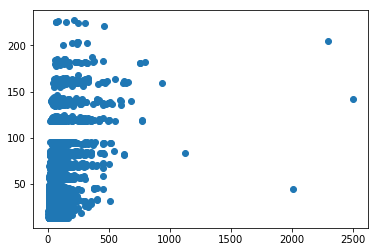

In [126]:
predictions = lm.predict(X_test)
plt.scatter(y_test,predictions)

In [124]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))

RMSE: 32.879339691865304


In [92]:
rf = RandomForestRegressor()

NameError: name 'RandomForestRegressor' is not defined

In [580]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [581]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [582]:
predicts = rf.predict(X_test)

In [583]:
print(y_test.shape, predicts.shape)

(52500,) (52500,)


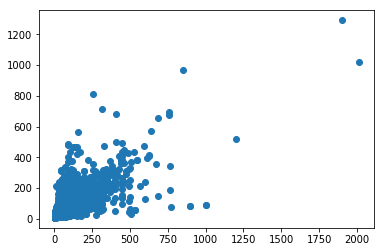

In [584]:
plt.scatter(y_test, predicts)

In [585]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, predicts)))

RMSE: 23.044996369054047


In [ ]:
importance = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(rf.feature_importances_)],axis=1)
importance.columns = ['feature','value']

plt.figure(figsize=(15,8))
sns.barplot(x="feature", y="value", data=importance).set_xticklabels(rotation=90,labels=X_train.columns)
print('')

In [ ]:
#print(test_data.columns.tolist())

In [493]:
X_test_t = test_data[['description_0', 'description_1', 'description_2', 'description_3', 'description_4', 'description_5', 'description_6', 'description_7', 'description_8', 'description_9', 'variety_0', 'variety_1', 'variety_2', 'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7', 'variety_8', 'variety_9', 'province_0', 'province_1', 'province_2', 'province_3', 'province_4', 'province_5', 'province_6', 'province_7', 'province_8', 'province_9', 'country_0', 'country_1', 'country_2', 'country_3', 'country_4', 'country_5', 'country_6', 'country_7', 'country_8', 'country_9', 'points', 'quality', 'div_points', 'sum_desc', 'sum_var', 'sum_prov', 'sum_country']]

In [127]:
# test_data['price'] = rf.predict(X_test_t)
# test_data['price'].head()

In [92]:
test_data[['id', 'price']].to_csv('bma_price_predicted_rmse14_20.csv', index=False)

In [ ]:
#pd.DataFrame(test_data_sss).to_csv('random_f.csv')

In [93]:
import pickle

In [94]:
pickle.dump(rf,open('rf_model_rmse14_20.sav','wb'))